### This notebook tries to forecast the No of jobs for pre-covid South Australia and post-covid South Australia using the Labour Force Statistical dataset provided by the Australian Bureau of Statistics

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 23
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['text.color'] = 'k'

In [2]:
emp_data = pd.read_excel("EmployUnemploy19-20.xlsx", sheet_name="SA_EmpTotal", parse_dates=[0])

In [3]:
emp_data.head(5)

,Time,Fulltime
0,1978-02-01,555.022868
1,1978-03-01,564.062301
2,1978-04-01,561.670398
3,1978-05-01,557.429914
4,1978-06-01,562.458089


In [4]:
emp_data.set_index('Time', inplace=True)

##### Visualizing Time series data

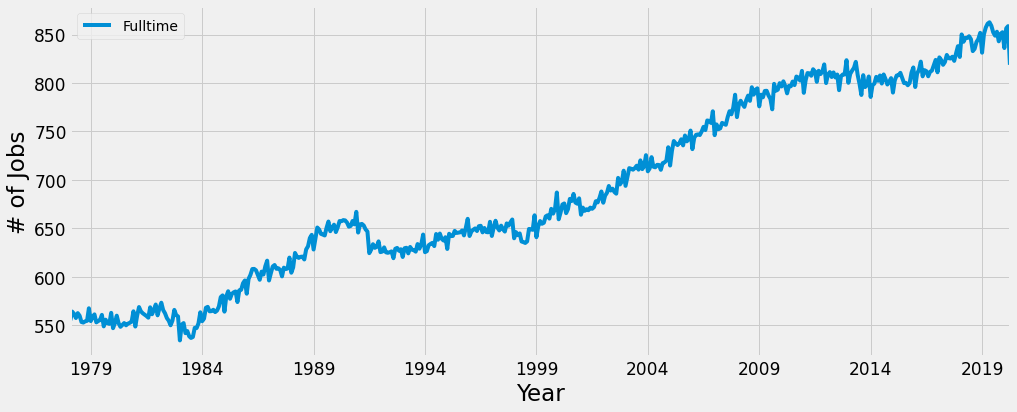

In [5]:
ax = emp_data.plot(figsize=(15, 6))

ax.set_xlabel('Year')
ax.set_ylabel('# of Jobs')

plt.legend()
plt.show()

##### Visualizing decomposed data in Seasonality, Trend and noise

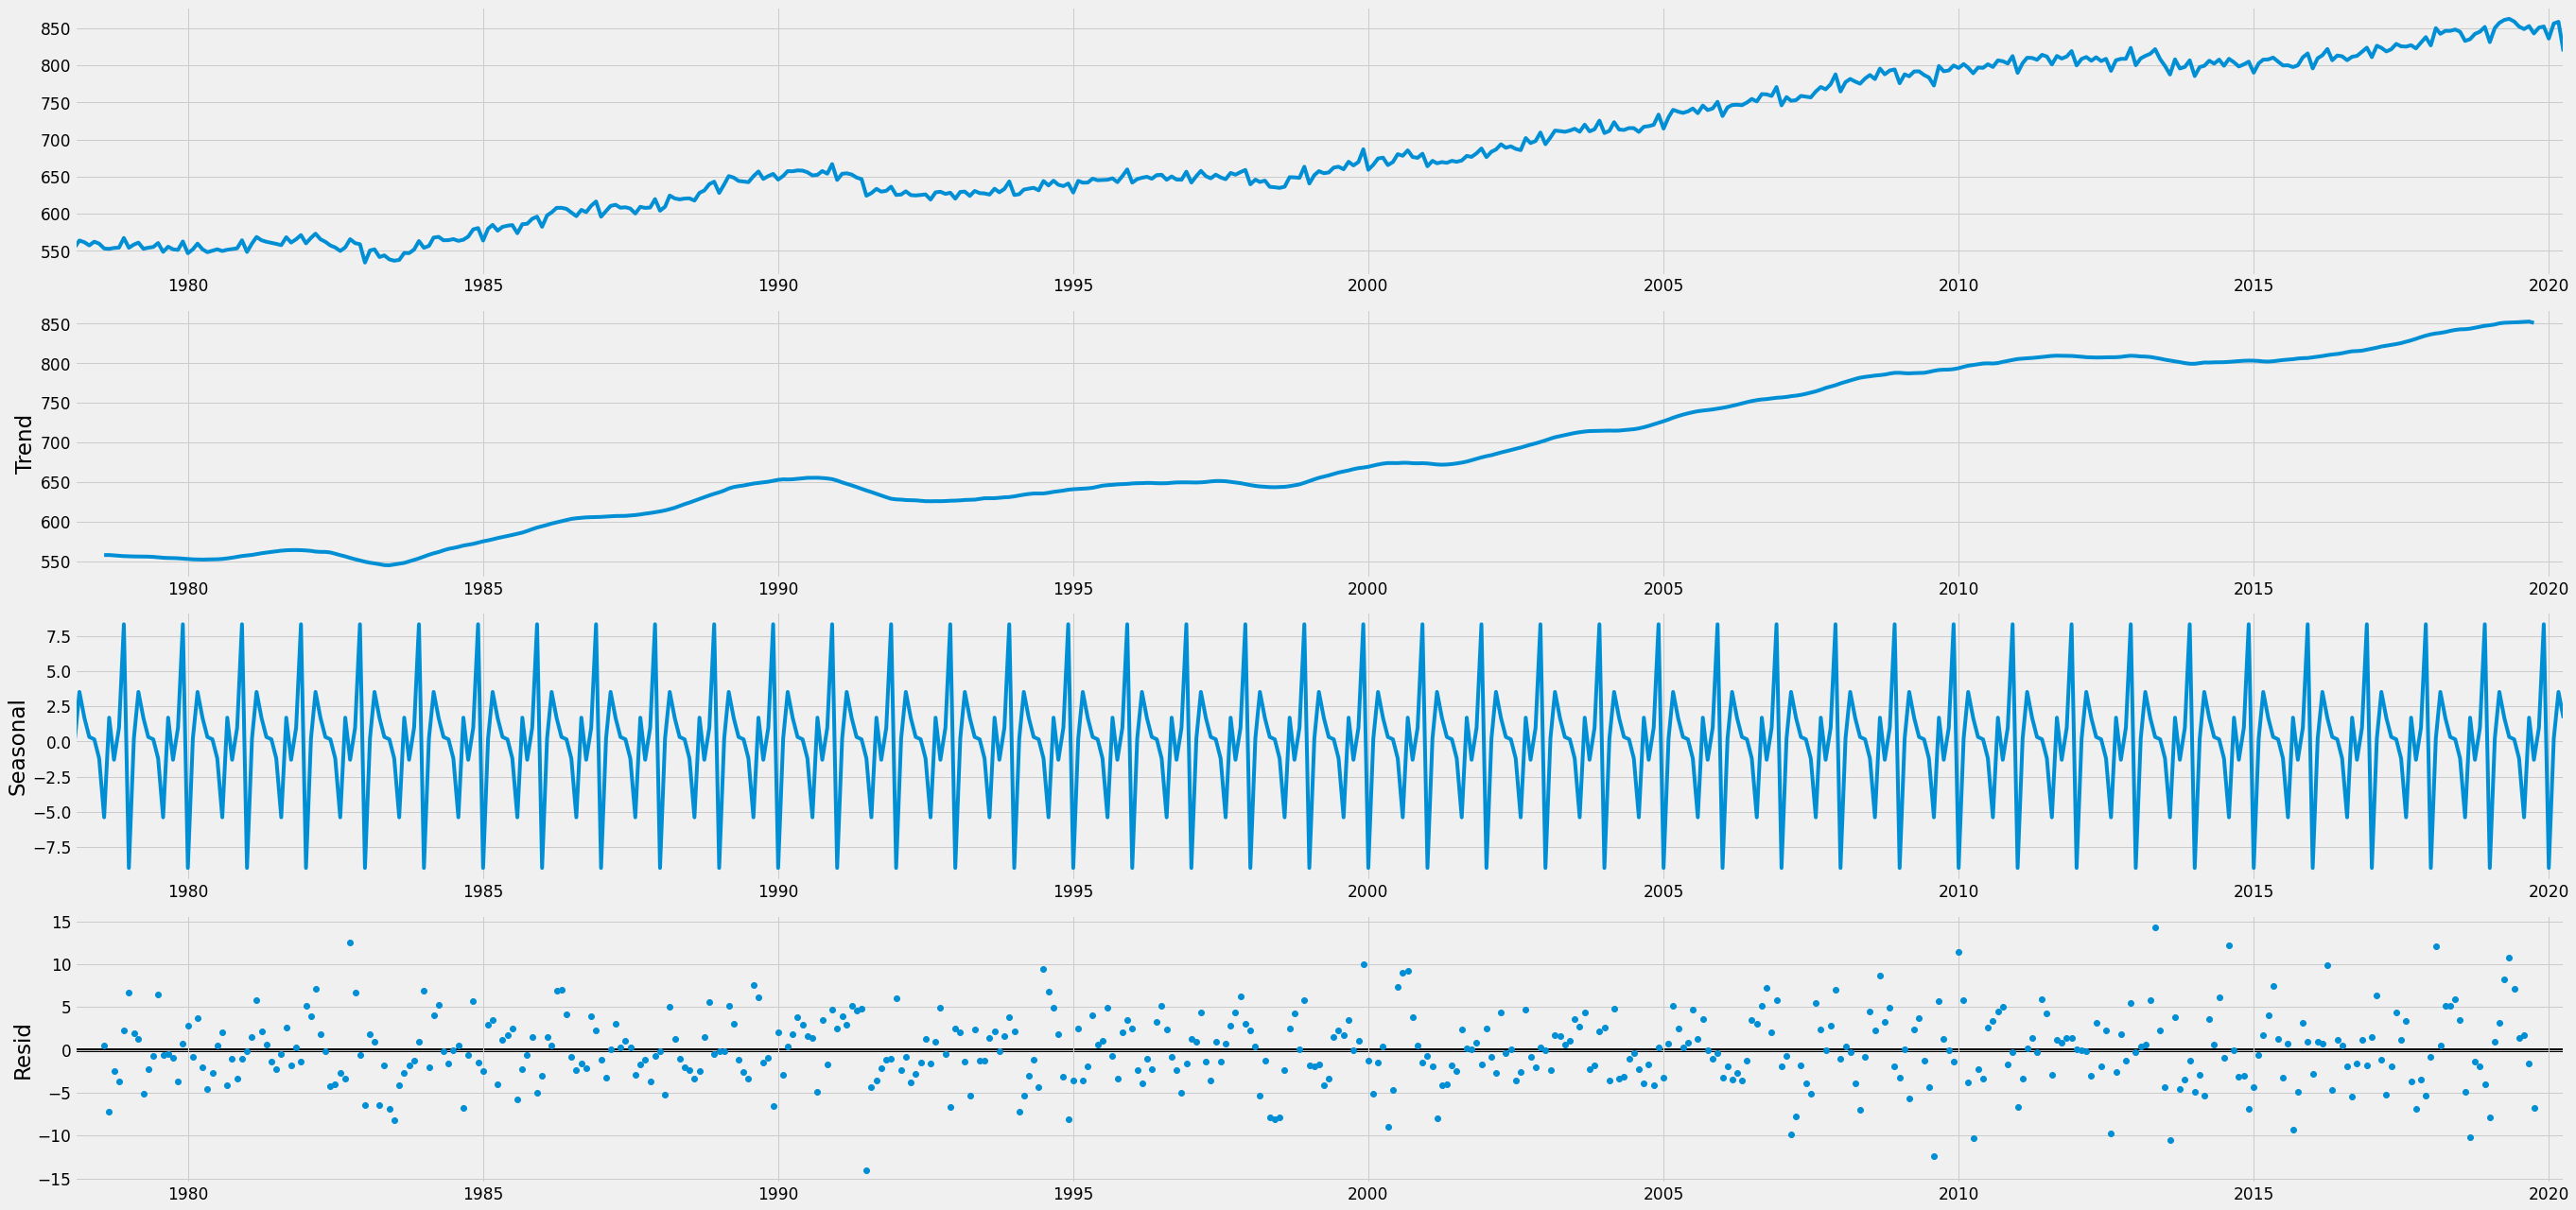

In [6]:
rcParams['figure.figsize'] = 38, 18
decomposition = sm.tsa.seasonal_decompose(emp_data, model='additive')
fig = decomposition.plot()
plt.show()

##### Firstly, trying to predict the jobs if there would have been no pandemic

In [7]:
emp_data_till_2019 = emp_data.iloc[:-7]

##### ARIMA Model

In [8]:
# parameter p,d and q stands for seasonality, trend and noice
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
# parameter selection for our model to find the optimal parameters for ARIMA Model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(emp_data_till_2019,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7945.871093215024
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7140.264411851945
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3953.560909733267
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3825.2890111324596
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3810.201951807793
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3802.0975091624177
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3820.1532176924593
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3766.689454827036
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7258.683467392345
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6474.091416315219
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3602.9401159440445
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3520.4382919797313
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3512.1838819699933
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3495.4289317545285
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3532.821508276207
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3468.439152558759
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3520.478215598291
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3302.6267312588716
AR

In [10]:
mod = sm.tsa.statespace.SARIMAX(emp_data_till_2019,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3018      0.040     -7.556      0.000      -0.380      -0.224
ma.S.L12      -0.8929      0.025    -35.927      0.000      -0.942      -0.844
sigma2        23.5447      1.243     18.936      0.000      21.108      25.982


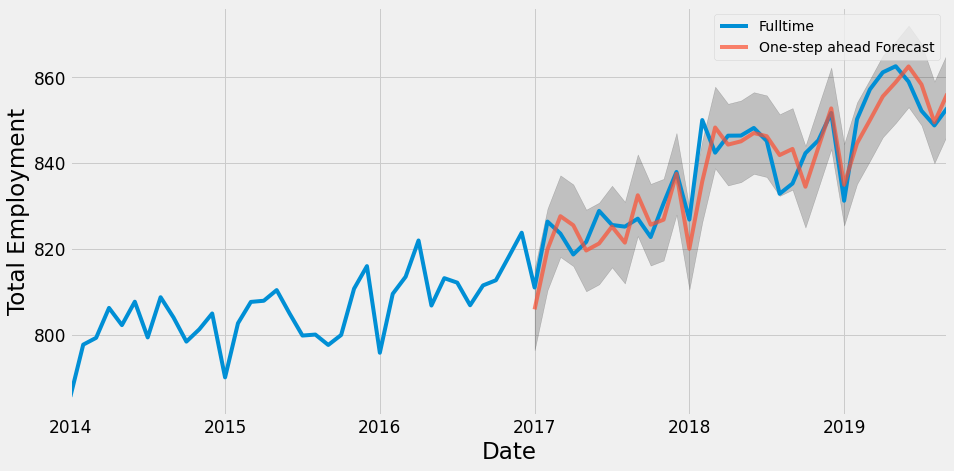

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = emp_data_till_2019['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Employment')

plt.legend()
plt.show()

##### The below graph shows the Job forecast if the Covid pandemic had not occurred. It clear from the graph that the Job count gradually increases

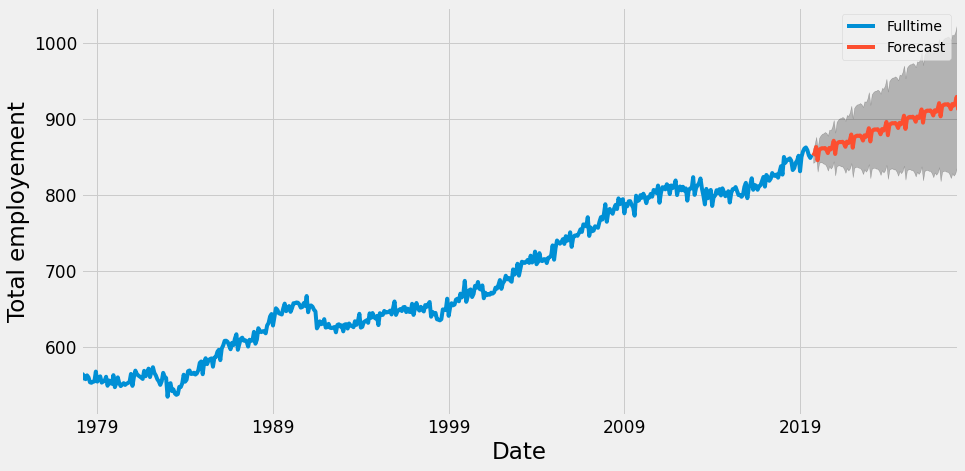

<Figure size 2736x1296 with 0 Axes>

In [12]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = emp_data_till_2019.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Total employement')
plt.legend()
plt.show()
plt.savefig('SAForecastPreCovid.png')

##### ARIMA Model

In [13]:
# parameter p,d and q stands for seasonality, trend and noice
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
# parameter selection for our model to find the optimal parameters for ARIMA Model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(emp_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8060.7134979108405
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7245.201390926528
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4013.044675575473
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3885.91454098338
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3877.659030267632
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3870.005275626091
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3882.478051702923
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3832.9305053351923
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7364.45369346892
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6569.497094508828
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3669.4585105639753
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3587.04622211304
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3588.74626747187
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3596.7475228999433
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3599.725232381585
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3542.6544953974344
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3597.724477018293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3384.4376839334805
ARIMA(0,

##### This model gives the lowest AIC: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:5134.295692976764

In [15]:
mod = sm.tsa.statespace.SARIMAX(emp_data,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3137      0.044     -7.072      0.000      -0.401      -0.227
ma.S.L12      -0.9051      0.026    -34.828      0.000      -0.956      -0.854
sigma2        26.8267      0.945     28.387      0.000      24.974      28.679


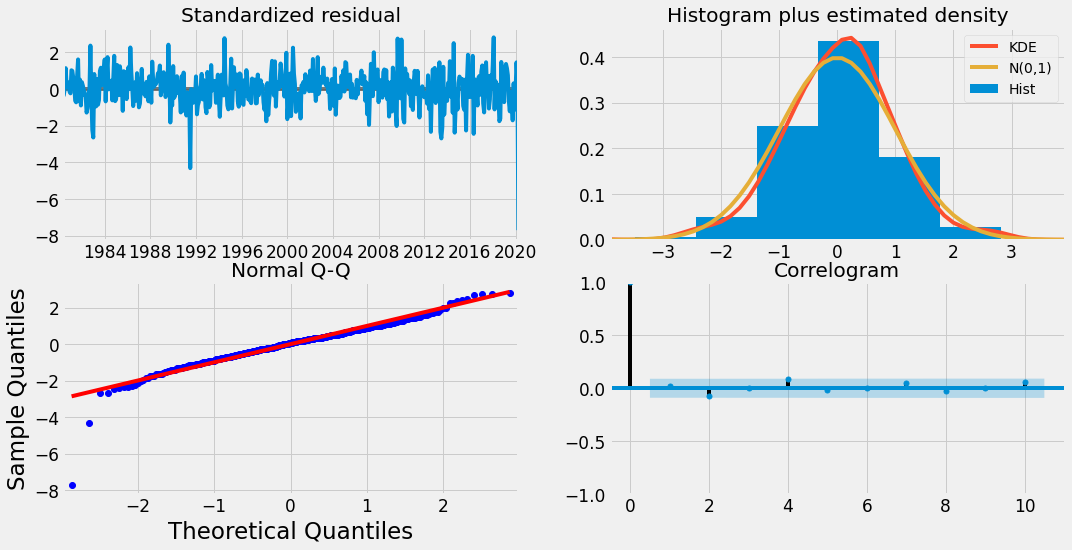

In [16]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Validating Forecasts

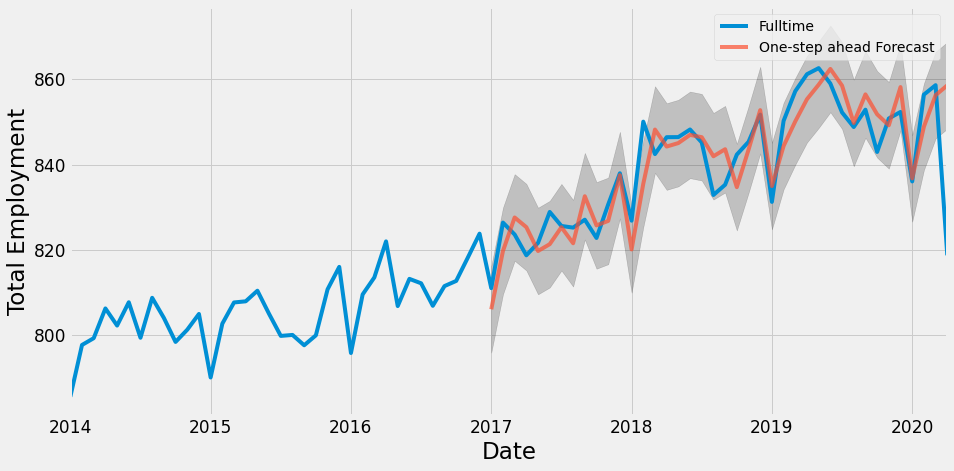

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = emp_data['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Employment')

plt.legend()
plt.show()

##### The below graph shows that due to covid 19 the job count plummets and after some time the job count gradually increases

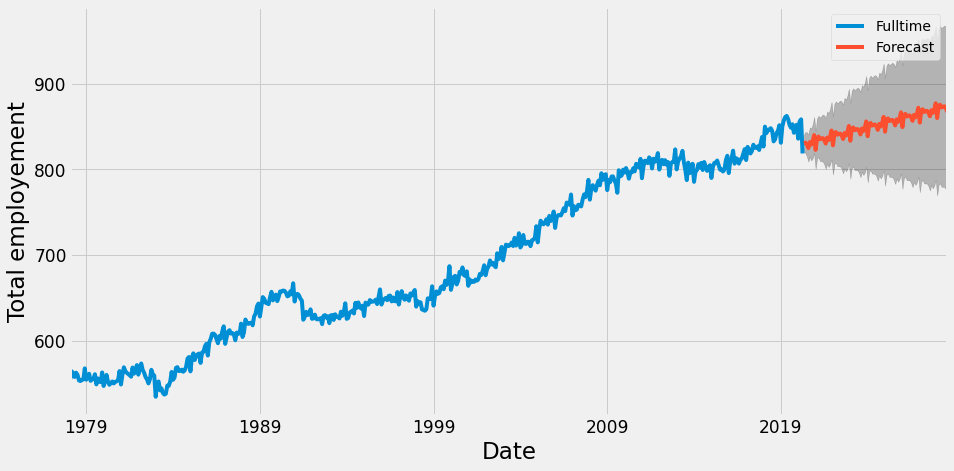

<Figure size 2736x1296 with 0 Axes>

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = emp_data.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Total employement')
plt.legend()
plt.show()
plt.savefig('SAForecastPostCovid.png')

### CONCLUSION

#### By comparing the above two graphs it is clear that the Job count that was forecasted before pandemic was higher as compared to the job count that is forecasted after pandemic